# TT1 - MDM UBA - 2025

**Tariff classification using NLP**

By Santiago Tedoldi

## Training a DistiltBERT for classification

In [ ]:
# Dependencies
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


### Raw dataset

In [2]:
colspecs = [(0, 6), (6, None)]
data_type = {'HS06': str}
df = pd.read_fwf('data/raw_data_HScodes_desc.txt',
                 colspecs=colspecs, header=None,
                 names=['HS06', 'GOODS_DESCRIPTION'],
                 dtype=data_type)

### Quick EDA

null and duplicated samples

dropping duplicates

analyzing tops and bottoms regarding frequencies

In [3]:
# Quick EDA
print("=== Quick EDA ===")

# Add HS02 (chapter) and HS04 (heading)
df['HS04'] = df['HS06'].str[:4]
df['HS02'] = df['HS06'].str[:2]

print("Nulls per column:")
print(df.isnull().sum(), "\n")

print("Duplicate rows:", df.duplicated().sum(), "\n")

# Function to build and display freq tables
def freq_table(col, name):
    vc      = df[col].value_counts().rename('count')
    rel     = df[col].value_counts(normalize=True).rename('rel_freq')
    cum     = rel.cumsum().rename('cum_freq')
    summary = pd.concat([vc, rel, cum], axis=1)
    summary['rel_freq'] = (summary['rel_freq'] * 100).round(2).astype(str) + '%'
    summary['cum_freq'] = (summary['cum_freq'] * 100).round(2).astype(str) + '%'

    print(f"## Samples per {name} ({col})\n")
    print("### Top 10")
    print(summary.head(10).to_markdown(), "\n")
    print("### Bottom 10")
    print(summary.tail(10).to_markdown(), "\n")

# Dropping duplicates
df.drop_duplicates(inplace=True)

# Chapter-level (HS02)
freq_table('HS02', 'chapter')

# Heading-level (HS04)
freq_table('HS04', 'heading')

# Subheading-level (HS06)
freq_table('HS06', 'subheading')

=== Quick EDA ===
Nulls per column:
HS06                 0
GOODS_DESCRIPTION    0
HS04                 0
HS02                 0
dtype: int64 

Duplicate rows: 232220 

## Samples per chapter (HS02)

### Top 10
|   HS02 |   count | rel_freq   | cum_freq   |
|-------:|--------:|:-----------|:-----------|
|     84 |   54901 | 20.5%      | 20.5%      |
|     85 |   33571 | 12.54%     | 33.04%     |
|     87 |   28476 | 10.63%     | 43.67%     |
|     73 |   16173 | 6.04%      | 49.71%     |
|     39 |   12218 | 4.56%      | 54.28%     |
|     90 |   11611 | 4.34%      | 58.61%     |
|     82 |    7972 | 2.98%      | 61.59%     |
|     94 |    7921 | 2.96%      | 64.55%     |
|     40 |    7526 | 2.81%      | 67.36%     |
|     83 |    4285 | 1.6%       | 68.96%     | 

### Bottom 10
|   HS02 |   count | rel_freq   | cum_freq   |
|-------:|--------:|:-----------|:-----------|
|     41 |      22 | 0.01%      | 99.96%     |
|     81 |      19 | 0.01%      | 99.97%     |
|     45 |      19 | 0

In [4]:
df

,HS06,GOODS_DESCRIPTION,HS04,HS02
0,271019,BRAKE FLUID DOT 4 50X200ML,2710,27
1,847710,PLASTIC INJECTION MOULD MODEL 21A 110G DSM1010...,8477,84
2,844399,LCD ASSEMBLY,8443,84
3,848280,BEARING 22238 KCAW33C3 BRAND MCB,8482,84
4,630900,USED HANDBAGS AND WALLETS,6309,63
...,...,...,...,...
499959,854239,PCB OPTIONAL ADD. KROPT V4.0 (NEW OUT PUT CARD),8542,85
499961,842091,CYLINDER (SDA80*10F003000001A),8420,84
499970,830249,BEOTIC DEVICE,8302,83
499981,901180,COMPOUND BINOCULAR MICROSCOPE,9011,90


Merging with HS06 nomenclature

In [5]:
df_hs06 = pd.read_csv('data/hs06_full_eng.csv', index_col='hs06', 
                      dtype={'hs06': str, 'full_eng': str},
                      usecols=['hs06', 'full_eng'])

In [6]:
# top 5 rows in HS06 nomemclature
print(df_hs06.head(5).to_markdown(), "\n")

# bottom 5 rows in HS06 nomemclature
print(df_hs06.tail(5).to_markdown(), "\n")

|   hs06 | full_eng                                                                              |
|-------:|:--------------------------------------------------------------------------------------|
| 010120 | Live horses, asses, mules and hinnies. && - Horses :                                  |
| 010121 | Live horses, asses, mules and hinnies. && - Horses : && -- Pure-bred breeding animals |
| 010129 | Live horses, asses, mules and hinnies. && - Horses : && -- Other                      |
| 010130 | Live horses, asses, mules and hinnies. && - Asses                                     |
| 010190 | Live horses, asses, mules and hinnies. && - Other                                     | 

|   hs06 | full_eng                                                                                                                                                                                                                                             |
|-------:|:------------------------------------

In [7]:
df = pd.merge(df, df_hs06,how='left', left_on='HS06', right_on='hs06')

In [8]:
print("Nulls per column:")
print(df.isnull().sum()/len(df), "\n")

Nulls per column:
HS06                 0.000000
GOODS_DESCRIPTION    0.000000
HS04                 0.000000
HS02                 0.000000
full_eng             0.045381
dtype: float64 



There are 4.5 % of goods with no HS full_eng available

They may are not updated codes

### Deep EDA

aggregate text statistics by HS level

performed in HSrecomm_EDA

Utils

In [9]:
# Utils f
def hs_frequencies_process(df, hs_codification = []):
    for hs_codi in hs_codification:

        df = df.merge(df[hs_codi].value_counts(), left_on=hs_codi, right_index=True)
        df.rename(columns={'count':f'{hs_codi}_samples'}, inplace=True)

    return df

def description_length(df, description_cols = []):
    for col in description_cols:

        df[f'{col}_len_words'] = df[col].apply(lambda x: len(x.split()))
        df[f'{col}_len_chars'] = df[col].apply(lambda x: len(x))

    return df

def subtokenization_indicator(description, tokenizer):
    words = description.lower().split()
    tokens = tokenizer.tokenize(description)
    return len(tokens)/len(words)

In [10]:
df.head()

,HS06,GOODS_DESCRIPTION,HS04,HS02,full_eng
0,271019,BRAKE FLUID DOT 4 50X200ML,2710,27,Petroleum oils and oils obtained from bitumino...
1,847710,PLASTIC INJECTION MOULD MODEL 21A 110G DSM1010...,8477,84,Machinery for working rubber or plastics or fo...
2,844399,LCD ASSEMBLY,8443,84,Printing machinery used for printing by means ...
3,848280,BEARING 22238 KCAW33C3 BRAND MCB,8482,84,"Ball or roller bearings. && - Other, including..."
4,630900,USED HANDBAGS AND WALLETS,6309,63,NaN


### DistilBERT model training

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizerFast, DistilBertModel

Sampling function

In [12]:
def bootstrap_sampling(df, test_fraction=0.1):
    # Determine the number of test samples
    n_test = int(len(df) * test_fraction)
    # Perform bootstrap sampling for the test set
    test_set = df.sample(n=n_test, replace=True)
    # Remove the test samples from the original dataframe to create the training set
    train_set = df.drop(test_set.index)
    
    return train_set, test_set

Dataset & DataLoader preparation

In [13]:
# Sampling for testing the pipeline
# df = df.sample(frac=0.01, random_state=42)

Pre-tokenizacion

In [14]:
class TokenizedDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'label': self.labels[idx]
        }

In [15]:
# Load the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Split the data into train and validation sets
train_df, val_df = bootstrap_sampling(df, test_fraction=0.1)

# Create label mappings
unique_labels = df['HS04'].unique()
label2id = {str(label): idx for idx, label in enumerate(unique_labels)}
id2label = {idx: str(label) for idx, label in enumerate(unique_labels)}

max_length = 300

# Tokenizing training data
train_encodings = tokenizer(
    list(train_df['GOODS_DESCRIPTION']), 
    truncation=True,
    padding='max_length',
    max_length=max_length,
    return_tensors='pt'
)
train_labels = torch.tensor([label2id[str(lbl)] for lbl in train_df['HS04']])

train_dataset = TokenizedDataset(train_encodings, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)

# Tokenizing val data
val_encodings = tokenizer(
    list(val_df['GOODS_DESCRIPTION']), 
    truncation=True,
    padding='max_length',
    max_length=max_length,
    return_tensors='pt'
)
val_labels = torch.tensor([label2id[str(lbl)] for lbl in val_df['HS04']])

val_dataset = TokenizedDataset(val_encodings, val_labels)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=0)


In [21]:
# labels
labels_dict = {
    'label2id': label2id,
    'id2label': id2label
}

# Save labels dictionary
with open('models/labels_dict.json', 'w') as f:
    json.dump(labels_dict, f, indent=4)

### Transfer learning

Model definition

Complexity adaptable to n_classes

In [16]:
# Define the custom model
class HSClassifier(nn.Module):
    def __init__(self, n_classes, fine_tune=False):
        super(HSClassifier, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        
        # Freeze the DistilBERT layers
        for param in self.distilbert.parameters():
            param.requires_grad = fine_tune # Whether to fine-tune the transformer model
        
        self.classifier = nn.Sequential(
            nn.Linear(self.distilbert.config.hidden_size, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024), # As our problem is unbalanced, we use batch normalization to stabilize the training
            nn.Dropout(0.3),
            nn.Linear(1024, n_classes)
        )
    
    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state[:, 0, :]  # Take <CLS> token representation
        logits = self.classifier(hidden_state)
        return logits

Training

In [17]:
from tqdm.auto import tqdm

# Accuracy functions
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item()

def top5_accuracy(outputs, labels):
    top5 = torch.topk(outputs, 5, dim=1).indices
    return sum([labels[i] in top5[i] for i in range(labels.size(0))])

def train_epoch(model, data_loader, criterion, optimizer, device):
    print("Model is training on:", next(model.parameters()).device)
    model.train()

    losses = []
    correct = 0
    correct_top5 = 0

    # wrap your DataLoader in a tqdm iterator
    loop = tqdm(data_loader, desc="Training", leave=False)
    for batch in loop:
        input_ids      = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels         = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss    = criterion(outputs, labels)

        correct      += accuracy(outputs, labels)
        correct_top5 += top5_accuracy(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # update the tqdm bar with current metrics
        loop.set_postfix(
            loss=f"{loss.item():.4f}",
            acc=f"{correct/len(data_loader.dataset):.4f}",
            top5=f"{correct_top5/len(data_loader.dataset):.4f}"
        )

    # make sure you end the line so console prompt isn't on the last bar
    print()

    return (
        correct      / len(data_loader.dataset),
        correct_top5 / len(data_loader.dataset),
        sum(losses)  / len(losses)
    )

def eval_model(model, data_loader, criterion, device):
    # print("Model is eval on:", next(model.parameters()).device)
    model = model.eval()
    losses = []
    correct = 0
    correct_top5 = 0
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)

            correct += accuracy(outputs, labels)
            correct_top5 += top5_accuracy(outputs, labels)
            
            losses.append(loss.item())
    
    # print("Input_ids device:", input_ids.device)
    # print("Labels device:", labels.device)
    # print("outputs device:", outputs.device)
    
    return (correct / len(data_loader.dataset), 
            correct_top5 / len(data_loader.dataset),
              np.mean(losses))

Transfer learning, without fine-tuning

In [18]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

True
0
NVIDIA GeForce RTX 3060 Laptop GPU


In [19]:
import time

# Initialize the model, loss function, and optimizer
model = HSClassifier(n_classes=len(label2id), fine_tune=False)
model_name = 'distiltbert_hs04_simple_classifier_transfer'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Training on {device}')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Initialize history dictionary
history = {
    'train_loss': [],
    'train_acc': [],
    'train_top5_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_top5_acc': []
}

# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    start_time = time.time()
    
    train_acc, train_top5_acc, train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    print(f'Train loss {train_loss} accuracy {train_acc} top5_accuracy {train_top5_acc}')
    
    val_acc, val_top5_acc, val_loss = eval_model(model, val_loader, criterion, device)
    print(f'Validation loss {val_loss} accuracy {val_acc} top5_accuracy {val_top5_acc}')

    end_time = time.time()
    epoch_time = end_time - start_time
    print(f"Epoch {epoch + 1} completed in {epoch_time/60:.2f} minutes.\n")    
    
    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_top5_acc'].append(train_top5_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_top5_acc'].append(val_top5_acc)

print("Training complete.")

Training on cuda
Epoch 1/10
----------
Model is training on: cuda:0


Training:   0%|          | 0/7572 [00:00<?, ?it/s]


Train loss 4.866914329614453 accuracy 0.20408424371742118 top5_accuracy 0.3615727805131719
Validation loss 3.593030991662503 accuracy 0.32059899917843004 top5_accuracy 0.5201658077526328
Epoch 1 completed in 24.29 minutes.

Epoch 2/10
----------
Model is training on: cuda:0


Training:   0%|          | 0/7572 [00:00<?, ?it/s]


Train loss 3.5490285057399364 accuracy 0.3251587927213296 top5_accuracy 0.5297176605570849
Validation loss 3.094296746071664 accuracy 0.3903951004555979 top5_accuracy 0.6028082754499963
Epoch 2 completed in 24.21 minutes.

Epoch 3/10
----------
Model is training on: cuda:0


Training:   0%|          | 0/7572 [00:00<?, ?it/s]


Train loss 3.2086219204933126 accuracy 0.3710363727161294 top5_accuracy 0.5845553184727834
Validation loss 2.868448518937634 accuracy 0.4253865113152588 top5_accuracy 0.6401150197923668
Epoch 3 completed in 24.32 minutes.

Epoch 4/10
----------
Model is training on: cuda:0


Training:   0%|          | 0/7572 [00:00<?, ?it/s]


Train loss 3.031308022964838 accuracy 0.3961171619954023 top5_accuracy 0.6134042105350046
Validation loss 2.7380926489402744 accuracy 0.4465232653670924 top5_accuracy 0.6624094405855553
Epoch 4 completed in 24.35 minutes.

Epoch 5/10
----------
Model is training on: cuda:0


Training:   0%|          | 0/7572 [00:00<?, ?it/s]


Train loss 2.9111689131252363 accuracy 0.4137112717037355 top5_accuracy 0.6338914637820526
Validation loss 2.6528052187022912 accuracy 0.46101277167824334 top5_accuracy 0.6766375382776907
Epoch 5 completed in 24.29 minutes.

Epoch 6/10
----------
Model is training on: cuda:0


Training:   0%|          | 0/7572 [00:00<?, ?it/s]


Train loss 2.8276222285869195 accuracy 0.42625785709274155 top5_accuracy 0.6462110550275075
Validation loss 2.5896337442500617 accuracy 0.4697139442826201 top5_accuracy 0.6849652699977593
Epoch 6 completed in 24.28 minutes.

Epoch 7/10
----------
Model is training on: cuda:0


Training:   0%|          | 0/7572 [00:00<?, ?it/s]


Train loss 2.7631752310734985 accuracy 0.4358287556181051 top5_accuracy 0.6564423001522924
Validation loss 2.5387776279677343 accuracy 0.4806184181044141 top5_accuracy 0.6946000448129062
Epoch 7 completed in 24.34 minutes.

Epoch 8/10
----------
Model is training on: cuda:0


Training:   0%|          | 0/7572 [00:00<?, ?it/s]


Train loss 2.7107986490120664 accuracy 0.44305955088176907 top5_accuracy 0.665035060277263
Validation loss 2.496985107767112 accuracy 0.4850250205392486 top5_accuracy 0.7024049592949436
Epoch 8 completed in 24.34 minutes.

Epoch 9/10
----------
Model is training on: cuda:0


Training:   0%|          | 0/7572 [00:00<?, ?it/s]


Train loss 2.667948197370727 accuracy 0.4503687623041144 top5_accuracy 0.6708213473546928
Validation loss 2.4644776743657557 accuracy 0.49253118231383974 top5_accuracy 0.706848905818209
Epoch 9 completed in 24.29 minutes.

Epoch 10/10
----------
Model is training on: cuda:0


Training:   0%|          | 0/7572 [00:00<?, ?it/s]


Train loss 2.627417896074778 accuracy 0.4567906329834872 top5_accuracy 0.6780232524546321
Validation loss 2.4384653471419178 accuracy 0.4967510643065203 top5_accuracy 0.7094256479199342
Epoch 10 completed in 24.30 minutes.

Training complete.


In [20]:
# Function to plot metrics
def plot_metric(history, metric, validation=True):
    plt.plot(history['train_' + metric], label=f'Training {metric}')
    if validation:
        plt.plot(history['val_' + metric], label=f'Validation {metric}')
        plt.title(f'Training and Validation {metric}')
    else:
        plt.title(f'Training {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    if validation:
        plt.legend()
    plt.grid(True)
    plt.show()

In [21]:
history_with_transfer = history

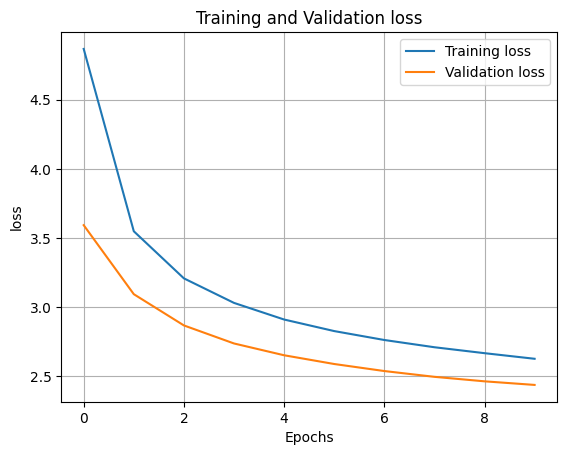

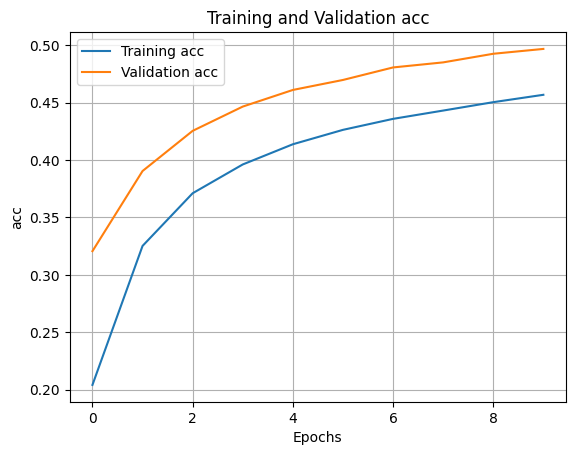

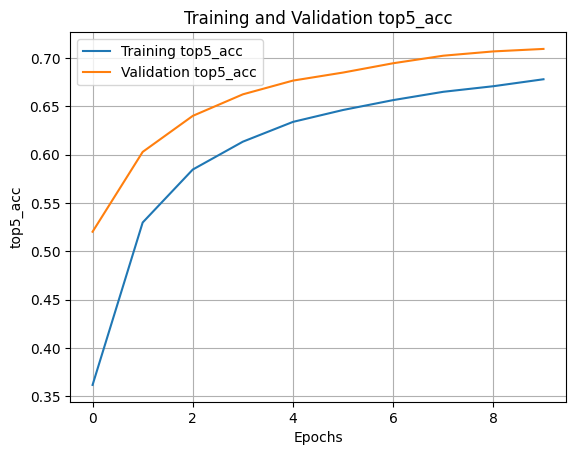

In [22]:
plot_metric(history_with_transfer, 'loss' )
plot_metric(history_with_transfer, 'acc' )
plot_metric(history_with_transfer, 'top5_acc' )

NOTE: took ~25 min/epoch (total 245 min), and it seems to need 3 or 4 more for convergence

In [23]:
from datetime import datetime

time_now = datetime.now().strftime('%d%m%Y_%H%M%S')

# Save the trained model
model_name = 'distiltbert_hs04_simple_classifier_transfer'
model_save_path = f'models/{model_name}_{num_epochs}epochs_{time_now}.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to models/distiltbert_hs04_simple_classifier_transfer_10epochs_13062025_114438.pth


Loading model for analysis

In [24]:
model_name = 'distiltbert_hs04_simple_classifier_transfer_8epochs_12062025_191051.pth'

model_save_path = os.path.join('models', model_name)

model_transfer = HSClassifier(n_classes=len(label2id), fine_tune=False)

model_transfer.load_state_dict(torch.load(model_save_path))

model_transfer.eval() # to set the model for inference

C:\Users\santt\AppData\Local\Temp\ipykernel_21620\4236870244.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_transfer.load_state_dict(torch.load(model_save_path))


HSClassifier(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Lin

HSDataset definition & Evaluation function

In [25]:
class HSDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.descriptions = dataframe['GOODS_DESCRIPTION'].tolist()
        self.labels = dataframe['HS04'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.descriptions[idx],
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt'
        )
        item = {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': self.labels[idx],
            'description': self.descriptions[idx]
        }
        return item


def predict_and_evaluate(
    model, tokenizer, unseen_sample, id2label,
    max_length=128, device='cpu', batch_size=32
):
    """
    Predicts the top 5 classes and their probabilities for an unseen sample using a given model and tokenizer.
    Calculates the accuracy for top 1 to top 5 predictions.
    Uses a DataLoader for GPU memory efficiency.
    """
    # Dataset & DataLoader
    dataset = HSDataset(unseen_sample, tokenizer, max_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    model.to(device)
    model.eval()

    all_top5_predicted_labels = []
    all_top5_predicted_probs = []
    all_true_labels = []
    all_descriptions = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probabilities = F.softmax(outputs, dim=1)
            top5_probs, top5_preds = torch.topk(probabilities, 5, dim=1)

            # Convert predictions and probabilities to lists
            for i in range(top5_preds.size(0)):
                pred_labels = [id2label[idx.item()] for idx in top5_preds[i]]
                pred_probs = [prob.item() for prob in top5_probs[i]]
                all_top5_predicted_labels.append(pred_labels)
                all_top5_predicted_probs.append(pred_probs)
            
            all_true_labels.extend(batch['label'])
            all_descriptions.extend(batch['description'])

    # Accuracy calculations
    accuracy_top1 = sum([
        all_true_labels[i] == all_top5_predicted_labels[i][0]
        for i in range(len(all_true_labels))
    ]) / len(all_true_labels)
    accuracy_top2 = sum([
        all_true_labels[i] in all_top5_predicted_labels[i][:2]
        for i in range(len(all_true_labels))
    ]) / len(all_true_labels)
    accuracy_top3 = sum([
        all_true_labels[i] in all_top5_predicted_labels[i][:3]
        for i in range(len(all_true_labels))
    ]) / len(all_true_labels)
    accuracy_top4 = sum([
        all_true_labels[i] in all_top5_predicted_labels[i][:4]
        for i in range(len(all_true_labels))
    ]) / len(all_true_labels)
    accuracy_top5 = sum([
        all_true_labels[i] in all_top5_predicted_labels[i][:5]
        for i in range(len(all_true_labels))
    ]) / len(all_true_labels)

    print(f"Accuracy Top-1: {accuracy_top1*100:.2f} %")
    print(f"Accuracy Top-2: {accuracy_top2*100:.2f} %")
    print(f"Accuracy Top-3: {accuracy_top3*100:.2f} %")
    print(f"Accuracy Top-4: {accuracy_top4*100:.2f} %")
    print(f"Accuracy Top-5: {accuracy_top5*100:.2f} %")


    # Results DataFrame
    results = pd.DataFrame({
        'Description': all_descriptions,
        'True Label': all_true_labels,
        'Top1': [labels[0] for labels in all_top5_predicted_labels],
        'Proba Top1': [probs[0] for probs in all_top5_predicted_probs],
        'Top2': [labels[1] for labels in all_top5_predicted_labels],
        'Proba Top2': [probs[1] for probs in all_top5_predicted_probs],
        'Top3': [labels[2] for labels in all_top5_predicted_labels],
        'Proba Top3': [probs[2] for probs in all_top5_predicted_probs],
        'Top4': [labels[3] for labels in all_top5_predicted_labels],
        'Proba Top4': [probs[3] for probs in all_top5_predicted_probs],
        'Top5': [labels[4] for labels in all_top5_predicted_labels],
        'Proba Top5': [probs[4] for probs in all_top5_predicted_probs],
    })
    results.set_index(unseen_sample.index, inplace=True)

    return results


Test with val_df

In [26]:
torch.cuda.empty_cache()

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Testing on {device}')

results_transfer = predict_and_evaluate(model_transfer, tokenizer, val_df, id2label, max_length=max_length, device=device)

Testing on cuda
Accuracy Top-1: 50.53 %
Accuracy Top-2: 60.74 %
Accuracy Top-3: 66.07 %
Accuracy Top-4: 69.35 %
Accuracy Top-5: 72.15 %


In [28]:
results_transfer

,Description,True Label,Top1,Proba Top1,Top2,Proba Top2,Top3,Proba Top3,Top4,Proba Top4,Top5,Proba Top5
3914,BEVEL GEAR (43A0002),8483,8483,0.544822,8708,0.192012,8431,0.071819,7318,0.013380,8409,0.012917
143735,NANO FACIAL STEAMER,8516,9018,0.052310,9503,0.043004,3926,0.020738,8536,0.020334,4016,0.019428
257095,DISINFECTION CABINET (KITCHEN UTENSIL),9403,3924,0.263304,7323,0.185360,7013,0.062289,7615,0.055679,8516,0.045250
238825,USED TOYOTA WISH 2010,8703,8703,0.993154,8704,0.002988,8702,0.001797,8708,0.000462,8711,0.000376
91527,RECORDER,8519,8519,0.266704,8521,0.112859,8518,0.072839,8525,0.040814,8527,0.031203
...,...,...,...,...,...,...,...,...,...,...,...,...
52434,USED 2006 TOYOTA ALPHARD CHASSIS NO: ANH10-015...,8703,8703,0.990470,8704,0.008496,8702,0.000735,8701,0.000062,8429,0.000039
108622,"CUTTING DISC,SIZE:230 X 3.2 X 22.23MM (For Met...",6804,6804,0.706328,8208,0.055425,8441,0.024155,3920,0.023623,8477,0.009250
243579,FACEBODY CREAM,3304,3304,0.593746,3305,0.071348,3405,0.047079,3401,0.046316,3402,0.021673
258750,FUEL COCK CG,8714,8714,0.108806,8409,0.075800,8413,0.058014,8708,0.056856,8421,0.043336


In [29]:
results_transfer.sort_values(by='Proba Top1', ascending=False).head(5)

,Description,True Label,Top1,Proba Top1,Top2,Proba Top2,Top3,Proba Top3,Top4,Proba Top4,Top5,Proba Top5
216648,NEW CKD MOTORCYCLE HUONIAO: MOD: GN125 ; CHS:L...,8711,8711,0.999956,8714,0.000011,8703,0.000011,4011,3.076671e-06,8712,2.813984e-06
137054,NEW CKD MOTORCYCLE HUONIAO: CHS:LJEPCJL03MA021...,8711,8711,0.999955,8703,0.000015,8714,0.000009,8712,6.041987e-06,4011,3.281818e-06
18312,315/80R22.5 M729 154M156L TL BRIDGESTONE TYRE,4011,4011,0.999954,4012,0.000040,4013,0.000003,4016,6.288894e-07,8708,3.435995e-07
194131,NEW CKD MOTORCYCLE HUONIAO: CHS:LJEPCJL09MA022...,8711,8711,0.999953,8703,0.000014,8714,0.000012,8712,6.138240e-06,4011,3.585154e-06
64969,NEW CKD MOTORCYCLE HUONIAO: CHS:LJEPCJL08MA021...,8711,8711,0.999952,8703,0.000015,8714,0.000010,8712,6.451803e-06,4011,3.346864e-06


In [30]:
results_transfer.sort_values(by='Proba Top1', ascending=False).tail(5)

,Description,True Label,Top1,Proba Top1,Top2,Proba Top2,Top3,Proba Top3,Top4,Proba Top4,Top5,Proba Top5
116730,VOTA,8448,8517,0.025446,3923,0.019474,3926,0.019168,2710,0.018774,8536,0.017493
260684,PALMOLIVE,3401,1902,0.024651,2103,0.024148,3924,0.019208,1905,0.018956,2202,0.014877
147342,BIDET,3922,7323,0.024425,3924,0.022723,8517,0.021058,3926,0.020405,3506,0.018620
228605,FREEHWEEL,8714,8714,0.022547,3402,0.022515,3808,0.020612,1704,0.018918,8518,0.016008
58769,MOTIFSIRON,5810,8536,0.021617,3808,0.019753,8205,0.019152,9403,0.018485,3926,0.016005


Saving results

In [39]:
results_transfer.to_csv('results/hs04_distiltbert_transfer_results.csv', index=True)

### Fine-tuned model

In [31]:
import time

# Initialize the model, loss function, and optimizer
model = HSClassifier(n_classes=len(label2id), fine_tune=True)
model_name = 'distiltbert_hs04_simple_classifier_finetuned'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Training on {device}')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Initialize history dictionary
history = {
    'train_loss': [],
    'train_acc': [],
    'train_top5_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_top5_acc': []
}

# Training the model
num_epochs = 3
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    start_time = time.time()
    
    train_acc, train_top5_acc, train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    print(f'Train loss {train_loss} accuracy {train_acc} top5_accuracy {train_top5_acc}')
    
    val_acc, val_top5_acc, val_loss = eval_model(model, val_loader, criterion, device)
    print(f'Validation loss {val_loss} accuracy {val_acc} top5_accuracy {val_top5_acc}')

    end_time = time.time()
    epoch_time = end_time - start_time
    print(f"Epoch {epoch + 1} completed in {epoch_time/60:.2f} minutes.\n")    
    
    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_top5_acc'].append(train_top5_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_top5_acc'].append(val_top5_acc)

print("Training complete.")

Training on cuda
Epoch 1/3
----------
Model is training on: cuda:0


Training:   0%|          | 0/7572 [00:00<?, ?it/s]


Train loss 3.153776044528823 accuracy 0.4387796794842693 top5_accuracy 0.6281258125358548
Validation loss 2.1610841137961248 accuracy 0.565053402046456 top5_accuracy 0.7614086190156099
Epoch 1 completed in 65.52 minutes.

Epoch 2/3
----------
Model is training on: cuda:0


Training:   0%|          | 0/7572 [00:00<?, ?it/s]


Train loss 1.9886428739381605 accuracy 0.5901806460666043 top5_accuracy 0.7881690652381168
Validation loss 1.8507780007564039 accuracy 0.6149451041900067 top5_accuracy 0.8045783852416163
Epoch 2 completed in 65.37 minutes.

Epoch 3/3
----------
Model is training on: cuda:0


Training:   0%|          | 0/7572 [00:00<?, ?it/s]


Train loss 1.6212264801293408 accuracy 0.6507220477348048 top5_accuracy 0.8385411292752283
Validation loss 1.7295099860023855 accuracy 0.638957353051012 top5_accuracy 0.8231010531032937
Epoch 3 completed in 65.42 minutes.

Training complete.


In [32]:
history_with_finetuned = history

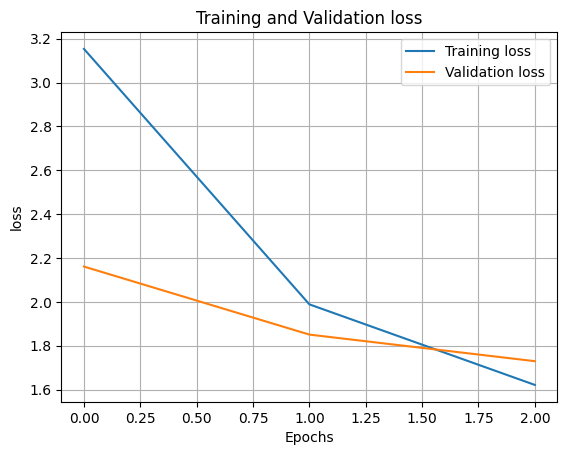

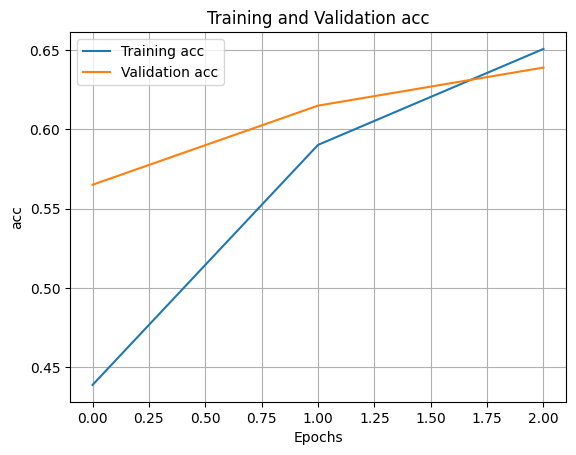

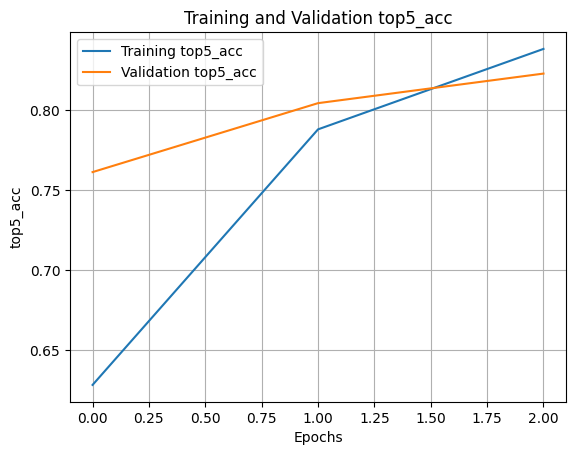

In [33]:
plot_metric(history_with_finetuned, 'loss')
plot_metric(history_with_finetuned, 'acc')
plot_metric(history_with_finetuned, 'top5_acc')

NOTE: took 65 min/epoch (total 196 min) and it is already overfitting

In [34]:
from datetime import datetime

time_now = datetime.now().strftime('%d%m%Y_%H%M%S')

# Save the trained model
model_save_path = f'{model_name}_{num_epochs}epochs_{time_now}.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to distiltbert_hs04_simple_classifier_finetuned_3epochs_13062025_150328.pth


Loading model for analysis

In [36]:
model_name = 'distiltbert_hs04_simple_classifier_finetuned_3epochs_13062025_150328.pth'

model_save_path = os.path.join('models', model_name)

model_finetuned = HSClassifier(n_classes=len(label2id), fine_tune=True)

model_finetuned.load_state_dict(torch.load(model_save_path))

model_finetuned.eval() # to set the model for inference

C:\Users\santt\AppData\Local\Temp\ipykernel_21620\2409705818.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_finetuned.load_state_dict(torch.load(model_save_path))

HSClassifier(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Lin

In [46]:
torch.cuda.empty_cache()

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Testing on {device}')

results_finetuned = predict_and_evaluate(model_finetuned, tokenizer, val_df, id2label, max_length=max_length, device=device)

Testing on cuda
Accuracy Top-1: 63.90 %
Accuracy Top-2: 73.43 %
Accuracy Top-3: 77.88 %
Accuracy Top-4: 80.64 %
Accuracy Top-5: 82.31 %


In [40]:
results_finetuned

,Description,True Label,Top1,Proba Top1,Top2,Proba Top2,Top3,Proba Top3,Top4,Proba Top4,Top5,Proba Top5
3914,BEVEL GEAR (43A0002),8483,8483,0.891349,8708,0.054235,8431,0.013001,8482,0.009579,8448,0.004437
143735,NANO FACIAL STEAMER,8516,8516,0.521912,8419,0.079620,7323,0.061562,3304,0.027125,3924,0.017655
257095,DISINFECTION CABINET (KITCHEN UTENSIL),9403,7323,0.259573,9403,0.203982,3924,0.144587,8418,0.078116,7615,0.060856
238825,USED TOYOTA WISH 2010,8703,8703,0.999423,8702,0.000097,8704,0.000054,8711,0.000053,8701,0.000004
91527,RECORDER,8519,8519,0.647193,8521,0.215078,8527,0.050980,9202,0.015427,9209,0.013578
...,...,...,...,...,...,...,...,...,...,...,...,...
52434,USED 2006 TOYOTA ALPHARD CHASSIS NO: ANH10-015...,8703,8703,0.999158,8704,0.000094,8702,0.000033,8711,0.000030,8701,0.000005
108622,"CUTTING DISC,SIZE:230 X 3.2 X 22.23MM (For Met...",6804,6804,0.979451,6805,0.006230,8202,0.004906,8448,0.001032,8208,0.000747
243579,FACEBODY CREAM,3304,3304,0.962618,3401,0.002785,3305,0.002579,3306,0.002198,3405,0.001302
258750,FUEL COCK CG,8714,8714,0.597063,8481,0.285380,8409,0.027844,8708,0.019319,8483,0.006910


In [41]:
results_finetuned.sort_values(by='Proba Top1', ascending=False).head(5)

,Description,True Label,Top1,Proba Top1,Top2,Proba Top2,Top3,Proba Top3,Top4,Proba Top4,Top5,Proba Top5
198984,RADIANT RELAXER ( 10 X 24 PCS ) SIZE 250GM,3305,3305,0.999908,3304,0.000037,3401,0.000012,3307,0.000003,6704,2.633221e-06
76630,SCANIA R450 TRACTOR UNIT,8701,8701,0.999876,8704,0.000012,8711,0.000006,8703,0.000006,8706,1.619098e-06
146375,USED VEHICLE TOYOTA VANGUARD,8703,8703,0.999874,8704,0.000019,8702,0.000008,8711,0.000005,8701,8.188755e-07
236201,SCANIA TRACTOR UNIT - R400,8701,8701,0.999860,8704,0.000020,8711,0.000010,8703,0.000009,8702,2.166234e-06
13412,SCANIA R420 HIGHLINE 6X2 SLEEPER CAB TRACTOR UNIT,8701,8701,0.999856,8704,0.000017,8703,0.000004,8706,0.000003,8705,2.638283e-06


In [42]:
results_finetuned.sort_values(by='Proba Top1', ascending=False).tail(5)

,Description,True Label,Top1,Proba Top1,Top2,Proba Top2,Top3,Proba Top3,Top4,Proba Top4,Top5,Proba Top5
147331,291814000000,2918,8418,0.027856,8536,0.025212,8443,0.022682,8482,0.020678,6907,0.018522
99724,GOWS,6208,8714,0.026654,8414,0.025095,7007,0.023666,9004,0.021332,7308,0.020599
218345,MAX STOCK,6110,9404,0.026351,8544,0.022810,3920,0.019492,3002,0.015571,6304,0.011402
208128,VIOO,7013,2710,0.025299,4911,0.018514,8518,0.016207,6114,0.013517,6204,0.012473
196472,CUELLO REJILLA,6210,9503,0.022528,9506,0.020151,8714,0.018453,8708,0.017257,8205,0.017050


Saving results

In [43]:
results_finetuned.to_csv('results/hs04_distiltbert_finetuned_results.csv', index=True)

### Partial fine-tuned

Re-defining the architecture

In [44]:

class HSClassifier(nn.Module):
    def __init__(self,
                 n_classes: int,
                 fine_tune: bool = False,
                 n_finetune_layers: int = 0):
        """
        Args:
          n_classes:      number of target classes
          fine_tune:      if True, you’ll unfreeze either all or the last layers
          n_finetune_layers:
                          • =0 (default) → if fine_tune=True, unfreeze *all* DistilBERT layers  
                          • >0             → unfreeze only that many of the *last* transformer blocks  
                          • ignored if fine_tune=False (encoder stays fully frozen)
        """
        super().__init__()
        self.distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")

        # Freeze everything by default
        for param in self.distilbert.parameters():
            param.requires_grad = False

        # If fine_tune, decide what to unfreeze
        if fine_tune:
            if n_finetune_layers > 0:
                # Unfreeze only the last `n_finetune_layers` transformer blocks
                for block in self.distilbert.transformer.layer[-n_finetune_layers:]:
                    for param in block.parameters():
                        param.requires_grad = True
            else:
                # n_finetune_layers == 0 → unfreeze *all* DistilBERT params
                for param in self.distilbert.parameters():
                    param.requires_grad = True

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.distilbert.config.hidden_size, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.3),
            nn.Linear(1024, n_classes),
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state[:, 0, :]  # Take <CLS> token representation
        logits = self.classifier(hidden_state)
        return logits

Fine-tuning last 2 layers

In [49]:
import time

# Initialize the model, loss function, and optimizer
model = HSClassifier(n_classes=len(label2id), fine_tune=True, n_finetune_layers=2)
model_name = 'distiltbert_hs04_simple_classifier_finetuned_2layers'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Training on {device}')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Initialize history dictionary
history = {
    'train_loss': [],
    'train_acc': [],
    'train_top5_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_top5_acc': []
}

# Training the model
num_epochs = 6
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    start_time = time.time()
    
    train_acc, train_top5_acc, train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    print(f'Train loss {train_loss} accuracy {train_acc} top5_accuracy {train_top5_acc}')
    
    val_acc, val_top5_acc, val_loss = eval_model(model, val_loader, criterion, device)
    print(f'Validation loss {val_loss} accuracy {val_acc} top5_accuracy {val_top5_acc}')

    end_time = time.time()
    epoch_time = end_time - start_time
    print(f"Epoch {epoch + 1} completed in {epoch_time/60:.2f} minutes.\n")    
    
    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_top5_acc'].append(train_top5_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_top5_acc'].append(val_top5_acc)

print("Training complete.")

Training on cuda
Epoch 1/6
----------
Model is training on: cuda:0


Training:   0%|          | 0/7572 [00:00<?, ?it/s]


Train loss 3.6152708338513553 accuracy 0.36978171417722877 top5_accuracy 0.5588595814227993
Validation loss 2.5356028380502225 accuracy 0.4969751288371051 top5_accuracy 0.7022929270296512
Epoch 1 completed in 37.90 minutes.

Epoch 2/6
----------
Model is training on: cuda:0


Training:   0%|          | 0/7572 [00:00<?, ?it/s]


Train loss 2.45361675973834 accuracy 0.5096307424359361 top5_accuracy 0.7185809151578435
Validation loss 2.160418312680622 accuracy 0.5555680035850324 top5_accuracy 0.7573007692882217
Epoch 2 completed in 38.16 minutes.

Epoch 3/6
----------
Model is training on: cuda:0


Training:   0%|          | 0/7572 [00:00<?, ?it/s]


Train loss 2.119994519228225 accuracy 0.5610098350371652 top5_accuracy 0.766843997243053
Validation loss 1.9862927765259464 accuracy 0.5902233176488162 top5_accuracy 0.7842632011352603
Epoch 3 completed in 38.37 minutes.

Epoch 4/6
----------
Model is training on: cuda:0


Training:   0%|          | 0/7572 [00:00<?, ?it/s]


Train loss 1.9089757641880714 accuracy 0.5951786443909747 top5_accuracy 0.7960024267737529
Validation loss 1.8729266305693304 accuracy 0.6088206736873553 top5_accuracy 0.8000224064530584
Epoch 4 completed in 38.06 minutes.

Epoch 5/6
----------
Model is training on: cuda:0


Training:   0%|          | 0/7572 [00:00<?, ?it/s]


Train loss 1.7424403396285026 accuracy 0.6227150975868458 top5_accuracy 0.8198244303478789
Validation loss 1.8150733143910143 accuracy 0.6237209649712451 top5_accuracy 0.8079766972888192
Epoch 5 completed in 38.28 minutes.

Epoch 6/6
----------
Model is training on: cuda:0


Training:   0%|          | 0/7572 [00:00<?, ?it/s]


Train loss 1.606438384546342 accuracy 0.6462564538562178 top5_accuracy 0.8385246206102428
Validation loss 1.7653115626731655 accuracy 0.6328329225483605 top5_accuracy 0.8170139666890731
Epoch 6 completed in 38.08 minutes.

Training complete.


In [50]:
history_with_finetuned_2layers = history

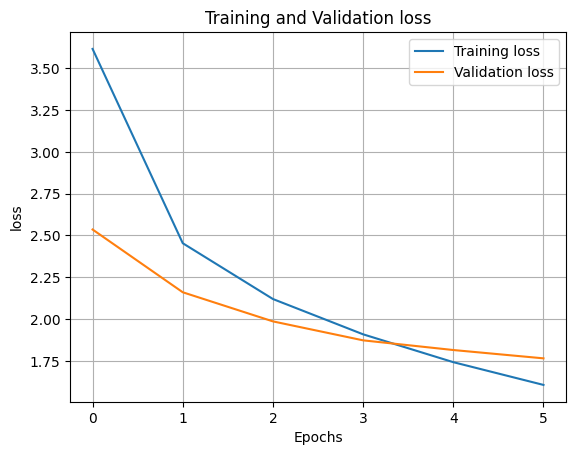

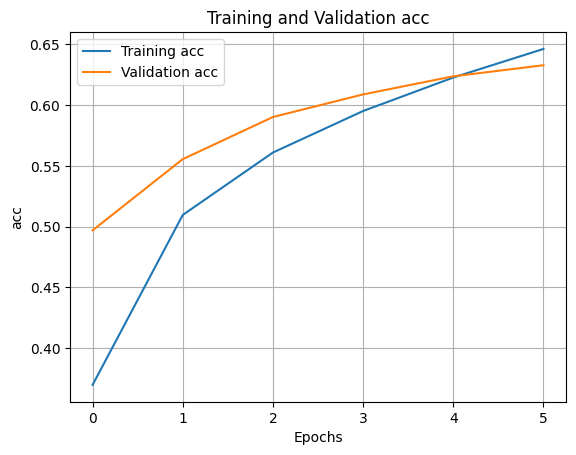

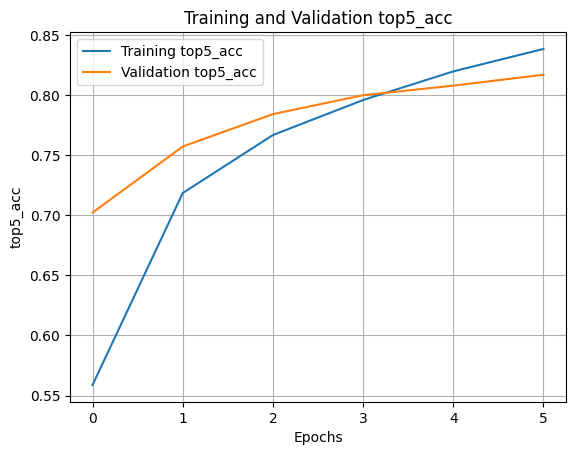

In [51]:
plot_metric(history_with_finetuned_2layers, 'loss')
plot_metric(history_with_finetuned_2layers, 'acc')
plot_metric(history_with_finetuned_2layers, 'top5_acc')

NOTE: took 38 min/epoch (230 min total) and it is already overfitting

In [52]:
from datetime import datetime

time_now = datetime.now().strftime('%d%m%Y_%H%M%S')

# Save the trained model
model_save_path = f'{model_name}_{num_epochs}epochs_{time_now}.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to distiltbert_hs04_simple_classifier_finetuned_2layers_6epochs_14062025_003324.pth


Loading model for analysis

In [53]:
model_name = 'distiltbert_hs04_simple_classifier_finetuned_2layers_6epochs_14062025_003324.pth'

model_save_path = os.path.join('models', model_name)

model_finetuned_2 = HSClassifier(n_classes=len(label2id), fine_tune=True, n_finetune_layers=2)

model_finetuned_2.load_state_dict(torch.load(model_save_path))

model_finetuned_2.eval() # to set the model for inference

C:\Users\santt\AppData\Local\Temp\ipykernel_21620\1492191101.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_finetuned_2.load_state_dict(torch.load(model_save_path

HSClassifier(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Lin

In [48]:
torch.cuda.empty_cache()

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Testing on {device}')

results_finetuned_2 = predict_and_evaluate(model_finetuned_2, tokenizer, val_df, id2label, max_length=max_length, device=device)

Testing on cuda
Accuracy Top-1: 63.28 %
Accuracy Top-2: 72.97 %
Accuracy Top-3: 77.15 %
Accuracy Top-4: 79.85 %
Accuracy Top-5: 81.70 %


In [55]:
results_finetuned_2

,Description,True Label,Top1,Proba Top1,Top2,Proba Top2,Top3,Proba Top3,Top4,Proba Top4,Top5,Proba Top5
3914,BEVEL GEAR (43A0002),8483,8483,0.867107,8708,0.046992,8448,0.036971,8422,0.008359,8714,0.006879
143735,NANO FACIAL STEAMER,8516,8516,0.969369,9503,0.007005,7323,0.002286,3924,0.001876,8510,0.001727
257095,DISINFECTION CABINET (KITCHEN UTENSIL),9403,9403,0.251126,3924,0.134935,7323,0.119689,8418,0.077727,7324,0.031028
238825,USED TOYOTA WISH 2010,8703,8703,0.995775,8702,0.002103,8704,0.001041,8711,0.000131,7007,0.000016
91527,RECORDER,8519,8519,0.556769,8521,0.234013,9207,0.053891,9202,0.035333,9209,0.015599
...,...,...,...,...,...,...,...,...,...,...,...,...
52434,USED 2006 TOYOTA ALPHARD CHASSIS NO: ANH10-015...,8703,8703,0.999284,8704,0.000149,8711,0.000122,8702,0.000076,8701,0.000011
108622,"CUTTING DISC,SIZE:230 X 3.2 X 22.23MM (For Met...",6804,6804,0.937857,8202,0.031720,8208,0.018099,8207,0.002442,8441,0.002157
243579,FACEBODY CREAM,3304,3304,0.979628,3306,0.003408,3405,0.003144,3402,0.002940,3305,0.002720
258750,FUEL COCK CG,8714,8481,0.823296,8207,0.035668,8431,0.028165,8714,0.021190,8467,0.008955


In [56]:
results_finetuned_2.sort_values(by='Proba Top1', ascending=False).head(5)

,Description,True Label,Top1,Proba Top1,Top2,Proba Top2,Top3,Proba Top3,Top4,Proba Top4,Top5,Proba Top5
215281,FLATBED SEMI TRAILER WITH CHASSIS# BIL 31106,8716,8716,0.999988,9503,0.000007,8704,1.445964e-06,9403,8.973758e-07,3922,2.626336e-07
126649,NEW 3 AXLE TANKER SEMI-TRAILER,8716,8716,0.999988,8704,0.000007,8701,8.543503e-07,8708,5.828219e-07,9503,3.471298e-07
234187,FLATBED SEMI TRAILER CHSS: LZ99FRB37M0YHC098,8716,8716,0.999985,8704,0.000004,8432,1.597238e-06,9503,9.581191e-07,9403,7.806648e-07
19168,32.5M3 BULK TANKER SEMI TRAILER,8716,8716,0.999981,8704,0.000004,9503,2.163359e-06,7326,2.005798e-06,4011,1.237607e-06
170097,SL ALBERO GREY (PRC) 22.5 X 90 STD,6907,6907,0.999979,6802,0.000002,6910,1.158853e-06,6902,1.102464e-06,5702,8.960888e-07


In [57]:
results_finetuned_2.sort_values(by='Proba Top1', ascending=False).tail(5)

,Description,True Label,Top1,Proba Top1,Top2,Proba Top2,Top3,Proba Top3,Top4,Proba Top4,Top5,Proba Top5
115686,GAOIL,2710,7323,0.029667,9403,0.023529,3004,0.022999,6304,0.020490,8714,0.019535
181250,BODY SHELLS (SEGMENTS) & HARDAWARE,8438,8207,0.028932,7318,0.027450,9503,0.023589,3304,0.021584,3824,0.018017
13742,BALBU,7011,9603,0.027533,1904,0.025077,1704,0.023428,3305,0.017740,3808,0.015904
54766,Shell materials,3407,3824,0.025525,0801,0.024976,4412,0.020854,3214,0.015480,1513,0.014277
188298,THYAME,0910,3105,0.020822,3808,0.020262,8516,0.020016,2710,0.018653,6506,0.016524


Saving results

In [58]:
results_finetuned_2.to_csv('results/hs04_distiltbert_finetuned_2layers_results.csv', index=True)

## Conclusions

DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased") was used to train a HSClassifier , using 3 approaches:

- Transfer learning (fixed encoder):
    - 10 epochs (25 min/epoch - 250 min)
    - Not enough training (estimated 15 epochs)
    - Top1 51 % | Top3 66 % | Top5 72 %

- Partial fine-tuning (last 2 layers):
    - 6 epochs (38 min/epoch - 229 min)
    - Top1 63 % | Top3 77 % | Top5 82 % 

- Fine-tuning (all layers):
    - 3 epochs (65 min/epoch - 196 min)
    - Top1 64 % | Top3 78 % | Top5 82 % 

Using a RTX 3060 Laptop GPU, training time was reduced x5 comparing with CPU.
